### Generate ensembles from equilibrated state

From the initial conditions, add randomness and run model forward using 10 ensemble members. When do members diverge and become independent?


In [1]:
import numpy as np
import xarray as xr
import pyqg
from pyqg import diagnostic_tools as tools
from pyqg import qg_model, particles
import matplotlib.pyplot as plt
from numpy.random import Generator, MT19937
from numpy.random import RandomState, SeedSequence

#### Initial Condition

In [2]:
year = 24*60*60*360.
twrite = 1000
tavestart = 2*year
tmax = 305596800.0

m_000 = pyqg.QGModel(tmax=tmax, twrite=twrite, tavestart=tavestart)

# Container for the BitGenerator with initialized random number generator
# REF: https://numpy.org/doc/stable/reference/random/generator.html
rg = Generator(MT19937(SeedSequence(123456789)))

# set upper and lower PV anomaly in spatial coordinates
sig = 1.e-6
qi = sig*np.vstack([rg.random((m_000.nx,m_000.ny))[np.newaxis,],
                  rg.random((m_000.nx,m_000.ny))[np.newaxis,]])

m_000.set_q(qi) 
m_000.run()

INFO:  Logger initialized
INFO: Step: 1000, Time: 7.20e+06, KE: 4.19e-07, CFL: 0.014
INFO: Step: 2000, Time: 1.44e+07, KE: 6.96e-07, CFL: 0.013
INFO: Step: 3000, Time: 2.16e+07, KE: 1.39e-06, CFL: 0.014
INFO: Step: 4000, Time: 2.88e+07, KE: 3.15e-06, CFL: 0.015
INFO: Step: 5000, Time: 3.60e+07, KE: 7.67e-06, CFL: 0.017
INFO: Step: 6000, Time: 4.32e+07, KE: 1.94e-05, CFL: 0.019
INFO: Step: 7000, Time: 5.04e+07, KE: 4.90e-05, CFL: 0.028
INFO: Step: 8000, Time: 5.76e+07, KE: 1.15e-04, CFL: 0.046
INFO: Step: 9000, Time: 6.48e+07, KE: 2.08e-04, CFL: 0.065
INFO: Step: 10000, Time: 7.20e+07, KE: 2.61e-04, CFL: 0.068
INFO: Step: 11000, Time: 7.92e+07, KE: 3.16e-04, CFL: 0.076
INFO: Step: 12000, Time: 8.64e+07, KE: 3.88e-04, CFL: 0.078
INFO: Step: 13000, Time: 9.36e+07, KE: 4.09e-04, CFL: 0.078
INFO: Step: 14000, Time: 1.01e+08, KE: 4.38e-04, CFL: 0.095
INFO: Step: 15000, Time: 1.08e+08, KE: 4.49e-04, CFL: 0.089
INFO: Step: 16000, Time: 1.15e+08, KE: 4.66e-04, CFL: 0.086
INFO: Step: 17000, Time

In [11]:
def test():
    '''Test the random seed generator.'''
    rg = Generator(MT19937(SeedSequence(123456789))); print(rg)
    rn1 = rg.random(10)
    
    rg = Generator(MT19937(SeedSequence(123456789)))
    rn2 = rg.random(10)
    
    rn3 = rg.random(10)
    
    comparison1 = rn1 == rn2
    assert comparison1.all(),"Random numbers generated from the same seed are different. They should be the same."
    
    comparison2 = rn1 == rn3
    assert comparison2.all()==False, "Comparison 2 should be False. The random seed was not reset."

    
test()

Generator(MT19937)


#### Ensemble Generator

#### Method 1

Run with snapshots for each ensemble and plot KE time series.


In [12]:
tmax = 20*year
m_001 = pyqg.QGModel(tmax=tmax, twrite=twrite, tavestart=tavestart)
m_002 = pyqg.QGModel(tmax=tmax, twrite=twrite, tavestart=tavestart)
m_003 = pyqg.QGModel(tmax=tmax, twrite=twrite, tavestart=tavestart)
m_004 = pyqg.QGModel(tmax=tmax, twrite=twrite, tavestart=tavestart)
m_005 = pyqg.QGModel(tmax=tmax, twrite=twrite, tavestart=tavestart)

m_001.set_q(m_000.q) 

m_002.set_q(m_000.q + sig*np.vstack([rg.random((m_000.nx,m_000.ny))[np.newaxis,],
                                     rg.random((m_000.nx,m_000.ny))[np.newaxis,]])) 

m_003.set_q(m_000.q + sig*np.vstack([rg.random((m_000.nx,m_000.ny))[np.newaxis,],
                                     rg.random((m_000.nx,m_000.ny))[np.newaxis,]])) 

m_004.set_q(m_000.q + sig*np.vstack([rg.random((m_000.nx,m_000.ny))[np.newaxis,],
                                     rg.random((m_000.nx,m_000.ny))[np.newaxis,]])) 

m_005.set_q(m_000.q + sig*np.vstack([rg.random((m_000.nx,m_000.ny))[np.newaxis,],
                                     rg.random((m_000.nx,m_000.ny))[np.newaxis,]])) 


INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized


In [13]:
#################################################### Ensemble member 001

# Initialize lists for the PV anomaly and EKE
q_001 = [m_000.q]
eke_001 = [[np.nan, np.nan]]
t_001 = [0]

for snapshot in m_001.run_with_snapshots(tsnapstart=m_001.t, tsnapint=m_001.dt):
    q_copy = m_001.q.copy() 
    q_001.append(q_copy) # PV anomaly
    t_001.append(m_001.t) # model time
    try:
        eke_001.append(m_001.get_diagnostic('EKE')) # mean eddy kinetic energy 
    except:
        eke_001.append([np.nan, np.nan])
        
# Convert to numpy arrays        
q_001_snapshots = np.stack(q_001)
EKE_001_snapshots = np.stack(eke_001)
t_001_snapshots = np.stack(t_001)


#################################################### Ensemble member 002

# Initialize lists for the PV anomaly and EKE
q_002 = [m_000.q]
eke_002 = [[np.nan, np.nan]]
t_002 = [0]

for snapshot in m_002.run_with_snapshots(tsnapstart=m_002.t, tsnapint=m_002.dt):
    q_copy = m_002.q.copy() 
    q_002.append(q_copy) # PV anomaly
    t_002.append(m_002.t) # model time
    try:
        eke_002.append(m_002.get_diagnostic('EKE')) # mean eddy kinetic energy 
    except:
        eke_002.append([np.nan, np.nan])
        
# Convert to numpy arrays        
q_002_snapshots = np.stack(q_002)
EKE_002_snapshots = np.stack(eke_002)
t_002_snapshots = np.stack(t_002)


#################################################### Ensemble member 003

# Initialize lists for the PV anomaly and EKE
q_003 = [m_000.q]
eke_003 = [[np.nan, np.nan]]
t_003 = [0]

for snapshot in m_003.run_with_snapshots(tsnapstart=m_003.t, tsnapint=m_003.dt):
    q_copy = m_001.q.copy() 
    q_003.append(q_copy) # PV anomaly
    t_003.append(m_003.t) # model time
    try:
        eke_003.append(m_003.get_diagnostic('EKE')) # mean eddy kinetic energy 
    except:
        eke_003.append([np.nan, np.nan])
        
# Convert to numpy arrays        
q_003_snapshots = np.stack(q_003)
EKE_003_snapshots = np.stack(eke_003)
t_003_snapshots = np.stack(t_003)

#################################################### Ensemble member 004

# Initialize lists for the PV anomaly and EKE
q_004 = [m_000.q]
eke_004 = [[np.nan, np.nan]]
t_004 = [0]

for snapshot in m_004.run_with_snapshots(tsnapstart=m_004.t, tsnapint=m_004.dt):
    q_copy = m_004.q.copy() 
    q_004.append(q_copy) # PV anomaly
    t_004.append(m_004.t) # model time
    try:
        eke_004.append(m_004.get_diagnostic('EKE')) # mean eddy kinetic energy 
    except:
        eke_004.append([np.nan, np.nan])
        
# Convert to numpy arrays        
q_004_snapshots = np.stack(q_004)
EKE_004_snapshots = np.stack(eke_004)
t_004_snapshots = np.stack(t_004)

#################################################### Ensemble member 005

# Initialize lists for the PV anomaly and EKE
q_005 = [m_000.q]
eke_005 = [[np.nan, np.nan]]
t_005 = [0]

for snapshot in m_005.run_with_snapshots(tsnapstart=m_005.t, tsnapint=m_005.dt):
    q_copy = m_005.q.copy() 
    q_005.append(q_copy) # PV anomaly
    t_005.append(m_005.t) # model time
    try:
        eke_005.append(m_005.get_diagnostic('EKE')) # mean eddy kinetic energy 
    except:
        eke_005.append([np.nan, np.nan])
        
# Convert to numpy arrays        
q_005_snapshots = np.stack(q_005)
EKE_005_snapshots = np.stack(eke_005)
t_005_snapshots = np.stack(t_005)


INFO: Step: 1000, Time: 7.20e+06, KE: 4.95e-04, CFL: 0.101
INFO: Step: 2000, Time: 1.44e+07, KE: 5.19e-04, CFL: 0.110
INFO: Step: 3000, Time: 2.16e+07, KE: 5.00e-04, CFL: 0.087
INFO: Step: 4000, Time: 2.88e+07, KE: 4.96e-04, CFL: 0.090
INFO: Step: 5000, Time: 3.60e+07, KE: 4.84e-04, CFL: 0.087
INFO: Step: 6000, Time: 4.32e+07, KE: 5.12e-04, CFL: 0.092
INFO: Step: 7000, Time: 5.04e+07, KE: 5.03e-04, CFL: 0.115
INFO: Step: 8000, Time: 5.76e+07, KE: 5.02e-04, CFL: 0.094
INFO: Step: 9000, Time: 6.48e+07, KE: 4.93e-04, CFL: 0.092
INFO: Step: 10000, Time: 7.20e+07, KE: 5.08e-04, CFL: 0.091
INFO: Step: 11000, Time: 7.92e+07, KE: 5.18e-04, CFL: 0.091
INFO: Step: 12000, Time: 8.64e+07, KE: 4.93e-04, CFL: 0.085
INFO: Step: 13000, Time: 9.36e+07, KE: 4.99e-04, CFL: 0.090
INFO: Step: 14000, Time: 1.01e+08, KE: 4.71e-04, CFL: 0.092
INFO: Step: 15000, Time: 1.08e+08, KE: 5.14e-04, CFL: 0.097
INFO: Step: 16000, Time: 1.15e+08, KE: 4.97e-04, CFL: 0.088
INFO: Step: 17000, Time: 1.22e+08, KE: 4.49e-04, 

INFO: Step: 52000, Time: 3.74e+08, KE: 4.83e-04, CFL: 0.092
INFO: Step: 53000, Time: 3.82e+08, KE: 4.81e-04, CFL: 0.101
INFO: Step: 54000, Time: 3.89e+08, KE: 4.86e-04, CFL: 0.100
INFO: Step: 55000, Time: 3.96e+08, KE: 4.76e-04, CFL: 0.105
INFO: Step: 56000, Time: 4.03e+08, KE: 4.88e-04, CFL: 0.089
INFO: Step: 57000, Time: 4.10e+08, KE: 5.11e-04, CFL: 0.091
INFO: Step: 58000, Time: 4.18e+08, KE: 5.04e-04, CFL: 0.084
INFO: Step: 59000, Time: 4.25e+08, KE: 5.50e-04, CFL: 0.099
INFO: Step: 60000, Time: 4.32e+08, KE: 5.34e-04, CFL: 0.095
INFO: Step: 61000, Time: 4.39e+08, KE: 4.91e-04, CFL: 0.087
INFO: Step: 62000, Time: 4.46e+08, KE: 4.62e-04, CFL: 0.091
INFO: Step: 63000, Time: 4.54e+08, KE: 4.70e-04, CFL: 0.097
INFO: Step: 64000, Time: 4.61e+08, KE: 4.98e-04, CFL: 0.081
INFO: Step: 65000, Time: 4.68e+08, KE: 5.20e-04, CFL: 0.102
INFO: Step: 66000, Time: 4.75e+08, KE: 5.29e-04, CFL: 0.113
INFO: Step: 67000, Time: 4.82e+08, KE: 5.20e-04, CFL: 0.095
INFO: Step: 68000, Time: 4.90e+08, KE: 4

INFO: Step: 17000, Time: 1.22e+08, KE: 5.01e-04, CFL: 0.120
INFO: Step: 18000, Time: 1.30e+08, KE: 4.50e-04, CFL: 0.084
INFO: Step: 19000, Time: 1.37e+08, KE: 4.70e-04, CFL: 0.083
INFO: Step: 20000, Time: 1.44e+08, KE: 4.90e-04, CFL: 0.086
INFO: Step: 21000, Time: 1.51e+08, KE: 4.95e-04, CFL: 0.098
INFO: Step: 22000, Time: 1.58e+08, KE: 4.88e-04, CFL: 0.103
INFO: Step: 23000, Time: 1.66e+08, KE: 4.93e-04, CFL: 0.098
INFO: Step: 24000, Time: 1.73e+08, KE: 4.97e-04, CFL: 0.091
INFO: Step: 25000, Time: 1.80e+08, KE: 4.82e-04, CFL: 0.096
INFO: Step: 26000, Time: 1.87e+08, KE: 4.98e-04, CFL: 0.104
INFO: Step: 27000, Time: 1.94e+08, KE: 4.92e-04, CFL: 0.089
INFO: Step: 28000, Time: 2.02e+08, KE: 4.77e-04, CFL: 0.096
INFO: Step: 29000, Time: 2.09e+08, KE: 4.47e-04, CFL: 0.085
INFO: Step: 30000, Time: 2.16e+08, KE: 4.53e-04, CFL: 0.093
INFO: Step: 31000, Time: 2.23e+08, KE: 4.85e-04, CFL: 0.083
INFO: Step: 32000, Time: 2.30e+08, KE: 4.73e-04, CFL: 0.092
INFO: Step: 33000, Time: 2.38e+08, KE: 4

INFO: Step: 68000, Time: 4.90e+08, KE: 4.63e-04, CFL: 0.098
INFO: Step: 69000, Time: 4.97e+08, KE: 4.77e-04, CFL: 0.088
INFO: Step: 70000, Time: 5.04e+08, KE: 4.81e-04, CFL: 0.096
INFO: Step: 71000, Time: 5.11e+08, KE: 4.99e-04, CFL: 0.087
INFO: Step: 72000, Time: 5.18e+08, KE: 5.11e-04, CFL: 0.093
INFO: Step: 73000, Time: 5.26e+08, KE: 5.07e-04, CFL: 0.104
INFO: Step: 74000, Time: 5.33e+08, KE: 5.07e-04, CFL: 0.093
INFO: Step: 75000, Time: 5.40e+08, KE: 4.91e-04, CFL: 0.092
INFO: Step: 76000, Time: 5.47e+08, KE: 5.02e-04, CFL: 0.118
INFO: Step: 77000, Time: 5.54e+08, KE: 4.92e-04, CFL: 0.096
INFO: Step: 78000, Time: 5.62e+08, KE: 4.83e-04, CFL: 0.085
INFO: Step: 79000, Time: 5.69e+08, KE: 4.83e-04, CFL: 0.099
INFO: Step: 80000, Time: 5.76e+08, KE: 4.85e-04, CFL: 0.096
INFO: Step: 81000, Time: 5.83e+08, KE: 4.96e-04, CFL: 0.083
INFO: Step: 82000, Time: 5.90e+08, KE: 4.96e-04, CFL: 0.102
INFO: Step: 83000, Time: 5.98e+08, KE: 4.95e-04, CFL: 0.094
INFO: Step: 84000, Time: 6.05e+08, KE: 4

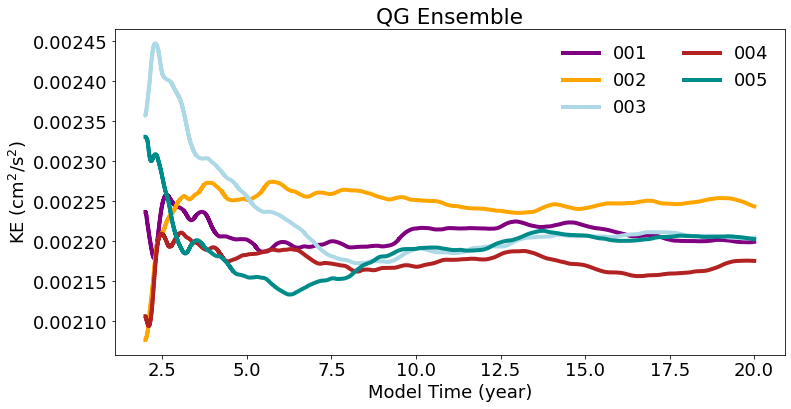

In [15]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12,6))
plt.plot(t_001_snapshots/year, EKE_001_snapshots[:,0], lw=4, color='purple', label='001')
plt.plot(t_002_snapshots/year, EKE_002_snapshots[:,0], lw=4, color='orange', label='002')
plt.plot(t_003_snapshots/year, EKE_003_snapshots[:,0], lw=4, color='lightblue', label='003')
plt.plot(t_004_snapshots/year, EKE_004_snapshots[:,0], lw=4, color='firebrick', label='004')
plt.plot(t_005_snapshots/year, EKE_005_snapshots[:,0], lw=4, color='darkcyan', label='005')
plt.legend(frameon=False, ncol=2)
plt.title('QG Ensemble')
plt.ylabel(r'KE ($\rmcm^{2}$/$\rms^{2}$)'); plt.xlabel('Model Time (year)');

#### Method 2

Wrap method 1 in a function. 

#### Save ensemble members 

Save as an xarray.dataset